In [1]:
import pandas as pd 

In [2]:
! mkdir 05_Load

A subdirectory or file 05_Load already exists.


In [3]:
OUTPUT_DIR = "05_Load"

# Read Transform Data

* `representitives_df` will contain the representivies Members of Parliament sourced from https://theyvoteforyou.org.au
* `aec_localities_df` will contain the mapping of voting localities to postcodes and suburbs sourced from https://electorate.aec.gov.au/

In [4]:
representitives_df = pd.read_csv("02_transform_they_vote_for_you/output.csv", dtype="str")
representitives_df.head()

,id,name_first,name_last,electorate,party
0,6,Anthony,Albanese,Grayndler,Australian Labor Party
1,13,Kevin,Andrews,Menzies,Liberal Party
2,40,Sharon,Bird,Cunningham,Australian Labor Party
3,69,Tony,Burke,Watson,Australian Labor Party
4,74,Anthony,Byrne,Holt,Australian Labor Party


In [5]:
aec_localities_df = pd.read_csv("04_transform_aec_electorates/output.csv", dtype="str")
aec_localities_df.head()

,electorate,locality_suburb,postcode,state
0,Adelaide,Adelaide,5000,SA
1,Adelaide,Allenby Gardens,5009,SA
2,Adelaide,Angle Park,5010,SA
3,Adelaide,Ashford,5035,SA
4,Adelaide,Blair Athol,5084,SA


# Normalising Dataframes

There are a number of columns in the dataframes that could be modelled as separate tables

* `aec_localities_df["state"]`
* `aec_localities_df["locality_suburb"]`
* `aec_localities_df["electorate"]`
* `representitives_df["electorate"]`
* `representitives_df["party"]`

## Convert Column to DataFrame

The `convert_column_to_fk` will help in the normalisation of the DataFrame, this will generate some additional csv's we will also need to import.

In [6]:
def convert_column_to_fk(df, column, output_dir):
    
    values = sorted(list(df[column].unique()))
    ids = range(1, len(values) + 1)    
    
    fk_df = pd.DataFrame(values, index = ids).reset_index()
    fk_df.columns = ["id", column]
    fk_df.to_csv(f"{output_dir}/{column}.csv", index = False)
    
    df[column] = df[column].replace(dict(zip(values, ids)))
    df = df.rename(columns = {column: f"{column}_id"})

    return df

# Electorates

Given electorates appears in both DataFrames let's check they have the same values.

In [7]:
sorted(representitives_df["electorate"].unique()) == sorted(aec_localities_df["electorate"].unique())

True

Now let's extract the values in `electorate_df` into another csv then replacing the values with references to the ids in the new csv. 

In [8]:
aec_localities_df = convert_column_to_fk(aec_localities_df, "electorate", OUTPUT_DIR)
aec_localities_df.head()

,electorate_id,locality_suburb,postcode,state
0,1,Adelaide,5000,SA
1,1,Allenby Gardens,5009,SA
2,1,Angle Park,5010,SA
3,1,Ashford,5035,SA
4,1,Blair Athol,5084,SA


Read in our new csv and see that id 1 is `"Adelaide"`.

In [9]:
electorates_df = pd.read_csv(f"{OUTPUT_DIR}/electorate.csv")
electorates_df.head()

,id,electorate
0,1,Adelaide
1,2,Aston
2,3,Ballarat
3,4,Banks
4,5,Barker


Now to update `representitives_df` to refer to the id values for `electorate` to achieve this we'll create a dictionary to pass to the `replace` method on the relevant series.

In [10]:
representitives_df.head()

,id,name_first,name_last,electorate,party
0,6,Anthony,Albanese,Grayndler,Australian Labor Party
1,13,Kevin,Andrews,Menzies,Liberal Party
2,40,Sharon,Bird,Cunningham,Australian Labor Party
3,69,Tony,Burke,Watson,Australian Labor Party
4,74,Anthony,Byrne,Holt,Australian Labor Party


In [11]:
electorate_replacments = dict(zip(electorates_df["electorate"].values, electorates_df["id"].values))

In [12]:
representitives_df["electorate"] = representitives_df["electorate"].replace(electorate_replacments)
representitives_df = representitives_df.rename(columns={"electorate": "electorate_id"})
representitives_df.head()

,id,name_first,name_last,electorate_id,party
0,6,Anthony,Albanese,65,Australian Labor Party
1,13,Kevin,Andrews,109,Liberal Party
2,40,Sharon,Bird,38,Australian Labor Party
3,69,Tony,Burke,145,Australian Labor Party
4,74,Anthony,Byrne,75,Australian Labor Party


# Normalise Representitives

Let's review the datatypes detected by Pandas.

In [13]:
representitives_df.dtypes

id               object
name_first       object
name_last        object
electorate_id     int64
party            object
dtype: object

Let's look at the number of Parties

In [14]:
representitives_df["party"].value_counts()

Australian Labor Party       68
Liberal Party                56
National Party               15
Liberal National Party        4
Independent                   3
SPK                           1
Centre Alliance               1
Australian Greens             1
Katter's Australian Party     1
CWM                           1
Name: party, dtype: int64

In [15]:
representitives_df.shape

(151, 5)

There is a fair bit of redundent information, so lets extract the `"party"` column into it's own csv. Thus allow us to enforce referential integrity between representitives and party in our sql database.

In [16]:
representitives_df = convert_column_to_fk(representitives_df, "party", OUTPUT_DIR)
representitives_df.head()

,id,name_first,name_last,electorate_id,party_id
0,6,Anthony,Albanese,65,2
1,13,Kevin,Andrews,109,8
2,40,Sharon,Bird,38,2
3,69,Tony,Burke,145,2
4,74,Anthony,Byrne,75,2


In [17]:
representitives_df.dtypes

id               object
name_first       object
name_last        object
electorate_id     int64
party_id          int64
dtype: object

# Normalise AEC Electorates

We've already normalised electorates, lets move onto the other columns. What we'll land up with is a table that maps electorates, localities, postcode, and state. 

Given the hierachical relationship between these geographical abstractions we could futher split this resulting DataFrame.

In [18]:
aec_localities_df.head()

,electorate_id,locality_suburb,postcode,state
0,1,Adelaide,5000,SA
1,1,Allenby Gardens,5009,SA
2,1,Angle Park,5010,SA
3,1,Ashford,5035,SA
4,1,Blair Athol,5084,SA


Before we proceed to extract the values in these columns lets just confirm that they do not contain unique values.

In [19]:
for col in aec_localities_df.columns:
    print(col, aec_localities_df[col].is_unique)

electorate_id False
locality_suburb False
postcode False
state False


## State

Let's start with state. How many unique values?

In [20]:
aec_localities_df["state"].describe()

count     17668
unique        8
top         NSW
freq       5005
Name: state, dtype: object

Only 8, let's have a peek at the distribution.

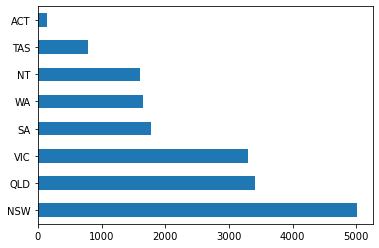

In [21]:
aec_localities_df["state"].value_counts().plot.barh()

Let's extract state into it's own csv.

In [22]:
aec_localities_df = convert_column_to_fk(aec_localities_df, "state", OUTPUT_DIR)
aec_localities_df.head()

,electorate_id,locality_suburb,postcode,state_id
0,1,Adelaide,5000,5
1,1,Allenby Gardens,5009,5
2,1,Angle Park,5010,5
3,1,Ashford,5035,5
4,1,Blair Athol,5084,5


## Post Code

How many unique postcodes?

In [23]:
aec_localities_df["postcode"].describe()

count     17668
unique     2658
top        0872
freq        474
Name: postcode, dtype: object

There is more variety of postcodes, plotting the entire distribution would not be feasiable, so lets just look at the top 5.

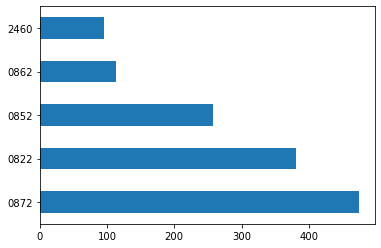

In [24]:
aec_localities_df["postcode"].value_counts().head().plot.barh()

Let's convert extract postcode.

In [25]:
aec_localities_df = convert_column_to_fk(aec_localities_df, "postcode", OUTPUT_DIR)
aec_localities_df.head()

,electorate_id,locality_suburb,postcode_id,state_id
0,1,Adelaide,1813,5
1,1,Allenby Gardens,1817,5
2,1,Angle Park,1818,5
3,1,Ashford,1838,5
4,1,Blair Athol,1873,5


## Locality / Suburb

In [26]:
aec_localities_df["locality_suburb"].describe()

count        17668
unique       15631
top       Red Hill
freq            10
Name: locality_suburb, dtype: object

Locality Suburb has the greatest variety, so we could potentially keep this column as is. But let's extract the column anyways.

In [27]:
aec_localities_df = convert_column_to_fk(aec_localities_df, "locality_suburb", OUTPUT_DIR)
aec_localities_df.head()

,electorate_id,locality_suburb_id,postcode_id,state_id
0,1,51,1813,5
1,1,165,1817,5
2,1,279,1818,5
3,1,453,1838,5
4,1,1364,1873,5


# Ensure No Duplicates

We should have no duplicates due to prior processing, but given we've applied some transformations let's recheck this.

In [28]:
assert(aec_localities_df.shape == aec_localities_df.drop_duplicates().shape)

In [29]:
aec_localities_df.shape

(17668, 4)

In [30]:
assert(representitives_df.shape == representitives_df.drop_duplicates().shape)

In [31]:
representitives_df.shape

(151, 5)

# Save For Import

Let's save the transformed DataFrames if needed for additional analysis.

In [32]:
representitives_df.to_csv(f"{OUTPUT_DIR}/representitive.csv", index = False)
aec_localities_df.to_csv(f"{OUTPUT_DIR}/aec_locality.csv", index = False)

# Do Import

In [ ]:
from sqlalchemy import create_engine
from config.key import postgres_password

This assumes you've already created a database, if not see `resources/create_database.sql`.

In [ ]:
connection_string = f"postgres:{postgres_password}@localhost:5432/auspol"
engine = create_engine(f'postgresql://{connection_string}') 

In [ ]:
def execute_sql_file(filepath, engine):
    with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as con:
        with open(filepath, "r") as schema_file: 
            return con.execute(schema_file.read(), autocommit=True)    

In [ ]:
execute_sql_file("resources/drop_tables.sql", engine)

In [ ]:
execute_sql_file("resources/schema.sql", engine)

In [ ]:
import_tables = [
    ("state.csv", "states"),
    ("party.csv", "parties"),    
    ("electorate.csv", "electorates"),
    ("postcode.csv", "postcodes"),
    ("locality_suburb.csv", "locality_suburbs"),
    ("representitive.csv", "representitives"),
    ("aec_locality.csv", "localities")
]

for item in import_tables:
    # loading as string as we don't want pandas 
    # to make assumptions about the datatypes
    # i.e. assuming that postcode '0820' and '820'
    # are the same because pandas has read postcode as integers
    print(f"Importing: {item[0]} into table {item[1]}")
    import_df = pd.read_csv(f"{OUTPUT_DIR}/{item[0]}", dtype="str")
    import_df.to_sql(name=item[1], con = engine, index = False, if_exists = "append")    
    print("\tdone!\n")